In [86]:
import pickle as pk 
import seaborn as sns
import numpy as np 
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate,GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC 
from sklearn.feature_selection import mutual_info_classif,f_classif,SelectKBest
%matplotlib inline
from sklearn.preprocessing._discretization import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix,roc_curve,auc,roc_auc_score
from sklearn.preprocessing import StandardScaler ,Normalizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import KNNImputer
from scipy.stats import fisher_exact
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.errors import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
import pandas as pd
from scipy.stats import pearsonr

In [87]:
 
def test_valid(model,x,y):
    res={}
    x_train,x_valid,y_train,y_valid=train_test_split(x,y,test_size=0.2,random_state=2)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_valid)
    fpr, tpr, thresholds = roc_curve(y_true=y_valid,y_score=y_pred)
    res['recall_score']=recall_score(y_pred=y_pred,y_true=y_valid)
    res['precision_score']=precision_score(y_pred=y_pred,y_true=y_valid)
    res['accuracy_score']=accuracy_score(y_pred=y_pred,y_true=y_valid)
    res['f1_score']=f1_score(y_pred=y_pred,y_true=y_valid)
    tn, fp, fn, tp=confusion_matrix(y_pred=y_pred,y_true=y_valid).ravel()
    print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')
    return res  

In [88]:
def replace_inf_with_max(df):
    
    for column in df.columns:
        max_value = df[column].replace([np.inf, -np.inf], np.nan).max()
        df[column] = df[column].replace([np.inf, -np.inf], max_value)
    return df
 

In [89]:
 
couleurs=['yellow','blue']
def distribution_target(df,titre=""):
    plt.figure(figsize=(8,8))
    plt.pie(x=[df[df['DEFAUT']==1].shape[0],df[df['DEFAUT']==0].shape[0]],colors=couleurs,explode=[0.05,0.05],shadow=False,autopct='%1.1f%%',)
    plt.legend(['defaut bancaire','non-defaut bancaire'])
    centre_circle = plt.Circle((0, 0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title('distribution des classe cibles'+titre)
    plt.show()
 

In [90]:
 
def cal_ratios(df):
    df_cal=pd.DataFrame(index=df.index)
    df_cal['solvabilite']=df['CAP_PROP']/df['TOT_BL']
    df_cal['liq_immediate']=(df['LIQ'])/df['PASS_COURANT']
    df_cal['equilibire']=df['FR']/df['BFR']
    df_cal['rot_cap_prop']=df['CA']/df['CAP_PROP']
    df_cal['roe']=df['RN']/df['CAP_PROP']
    df_cal['rot_actif']=df['CA']/df['TOT_BL']
    df_cal['marge_net']=df['RN']/df['CA']
    df_cal['liq_cour']=(df['ACT_COURANT'])/df['PASS_COURANT']
    df_cal['aut_fin']=df['CAP_PROP']/(df['CAP_PROP']+df['DS'])
    df_cal['couv_det']=df['DS']/df['CFN']
    df_cal['leverage_financier']=df['PASS_COURANT']/df['CAP_PROP']
    df_cal['endettement']=df['DS']/df['FPN']
    df_cal['DEFAUT']=df['DEFAUT']
    return df_cal

In [91]:
 
def make_mi_scores(x, y,titre=''):
    mi_scores = mutual_info_classif(x, y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    dfmi=pd.DataFrame(mi_scores)
    sns.barplot(x=dfmi['MI Scores'],y=dfmi.index)
    plt.title('MI score '+titre)
    plt.show()
    return dfmi.index


In [92]:
 
def extreme_values_1(x,col):
    d=x.copy()
    x1=d[[col]].sort_values(by=col)
    x1_min=x1[0:int(x1.__len__()*0.05)]
    x1_mid=x1[int(x1.__len__()*0.05):int(x1.__len__()*0.95)]
    x1_max=x1[int(x1.__len__()*0.95):]
    x1_max[col]=float(x1_mid.max())
    x1_min[col]=float(x1_mid.min())
    res=x1_min.append(x1_mid)
    res=res.append(x1_max)
    d[col]=res[col]
    return d


In [93]:
 
def extreme_values(x):
    d=x.copy()
    cols=['solvabilite', 'liq_immediate', 'equilibire', 'rot_cap_prop', 'roe',
       'rot_actif', 'marge_net', 'liq_cour', 'aut_fin', 'couv_det',
       'leverage_financier', 'endettement']
    for col in cols:
        d=extreme_values_1(d,col)
    return d

In [94]:
 
def corr_check(x):
    x1=extreme_values(x)
    plt.figure(figsize=(10,6))
    plt.title('correlation lineaire entre les variables' )
    sns.heatmap(x1.corr(method='pearson'),xticklabels=True,yticklabels=True,annot=True)
    plt.show()

In [95]:
 
def underSampling_RENN(df):
    x=df.iloc[:,0:-1].copy()
    y=df[['DEFAUT']].copy()
    renn=RepeatedEditedNearestNeighbours(n_neighbors=20)
    x,y=renn.fit_resample(x,y)
    return x,y

In [96]:
df=pd.read_csv("data.csv")
df.drop(columns=['Unnamed: 0'],inplace=True)
df

,CAP_PROP,TOT_BL,LIQ,PASS_COURANT,FR,BFR,CA,RN,ACT_COURANT,DS,CFN,FPN,DEFAUT
0,-570.818329,263.420337,5.620334,657.990689,-479.870894,-373.014838,824.667248,5.640226,178.119795,176.247977,24.943667,-570.818329,0
1,0.000000,93.577442,1.237800,0.000000,0.000000,92.339642,0.000000,0.000000,93.577442,0.000000,0.000000,0.000000,0
2,7008.000000,7323.000000,54.000000,315.000000,565.000000,514.000000,0.000000,704.000000,880.000000,0.000000,704.000000,7008.000000,0
3,109.000000,136.000000,25.000000,27.000000,102.000000,77.000000,369.000000,88.000000,129.000000,0.000000,90.000000,109.000000,0
4,61.390000,327.724000,48.131000,172.195000,58.287000,15.043000,257.303000,12.199000,230.482000,94.139000,36.296000,61.390000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,452.168000,1032.705000,50.655000,474.057000,526.406000,545.798000,954.838000,52.086000,1000.463000,106.480000,66.909000,452.168000,0
8374,-159.746445,30.623658,1.709029,35.673377,-13.865799,-15.574828,122.924498,30.377149,21.807578,154.696726,50.689857,-159.746445,0
8375,266.315000,648.941000,25.455000,306.088000,136.346000,188.161000,325.175000,28.712000,442.434000,76.538000,84.557000,266.315000,0
8376,140.000000,328.000000,0.000000,188.000000,140.000000,170.000000,543.000000,99.000000,328.000000,0.000000,99.000000,140.000000,1


In [97]:
df.describe()

,CAP_PROP,TOT_BL,LIQ,PASS_COURANT,FR,BFR,CA,RN,ACT_COURANT,DS,CFN,FPN,DEFAUT
count,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000,8378.000000
mean,893.917977,1637.317119,85.080967,562.275799,192.397523,235.175102,400.474294,29.385995,769.668850,160.479835,53.867510,894.276754,0.048341
std,18703.553785,19521.661901,1199.003199,2058.488888,3334.083596,3303.326138,281.625396,805.779860,4183.410829,1225.596214,819.122507,18703.550369,0.214498
min,-20277.000000,0.000043,0.000000,0.000000,-29147.000000,-18811.000000,0.000000,-13150.000000,0.000000,0.000000,-12950.000000,-20277.000000,0.000000
25%,39.000000,188.375003,2.743662,64.134719,-10.580000,-14.000000,161.000000,0.000000,117.619766,0.000000,5.647008,39.254750,0.000000
50%,113.086089,388.597898,11.853072,184.437614,52.905212,47.399377,358.833841,18.623258,263.073968,0.000000,32.140885,113.218901,0.000000
75%,259.000000,778.996804,45.545750,435.199723,160.932026,164.640086,617.195159,48.965423,526.000000,53.459226,72.114293,259.000000,0.000000
max,882239.000000,887816.000000,99609.243000,71008.000000,127759.000000,136436.000000,999.077000,43592.000000,137972.000000,58239.000000,44367.000000,882239.000000,1.000000


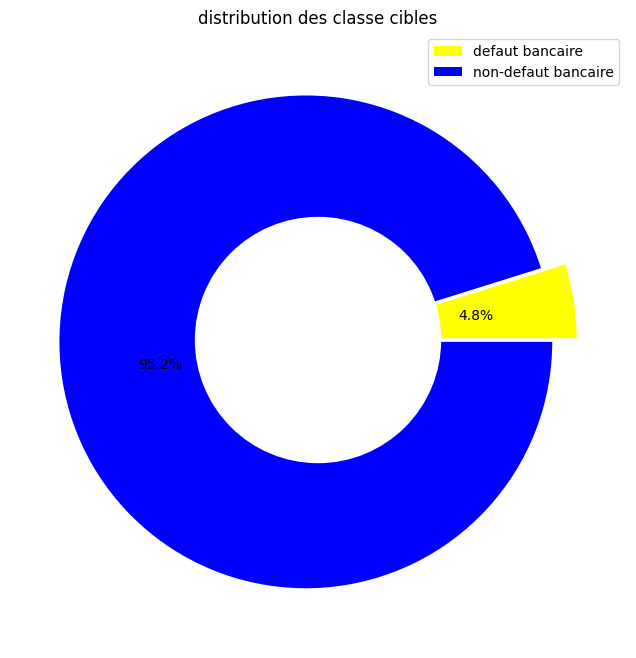

In [98]:
distribution_target(df)

In [99]:
 

df=cal_ratios(df)

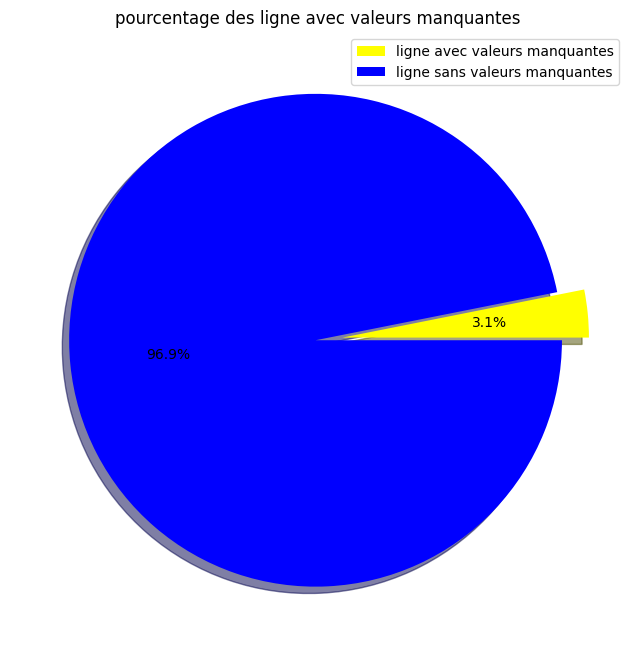

In [100]:
plt.figure(figsize=(8,8))
plt.pie(x=[df.shape[0]-df.dropna().shape[0],df.dropna().shape[0]],colors=couleurs,explode=[0.1,0.01],shadow=True,autopct='%1.1f%%')
plt.legend(['ligne avec valeurs manquantes','ligne sans valeurs manquantes'])
plt.title('pourcentage des ligne avec valeurs manquantes')
plt.show()

In [101]:

ab_values_indexes={370,
 502,
 1113,
 1446,
 1709,
 1890,
 1972,
 2032,
 2192,
 2300,
 2707,
 3006,
 3024,
 3239,
 3353,
 3502,
 3596,
 3767,
 4315,
 4360,
 4635,
 4875,
 4906,
 5066,
 5258,
 5327,
 5410,
 5537,
 5693,
 5710,
 5774,
 5985,
 6038,
 6172,
 6878,
 6925,
 7633}

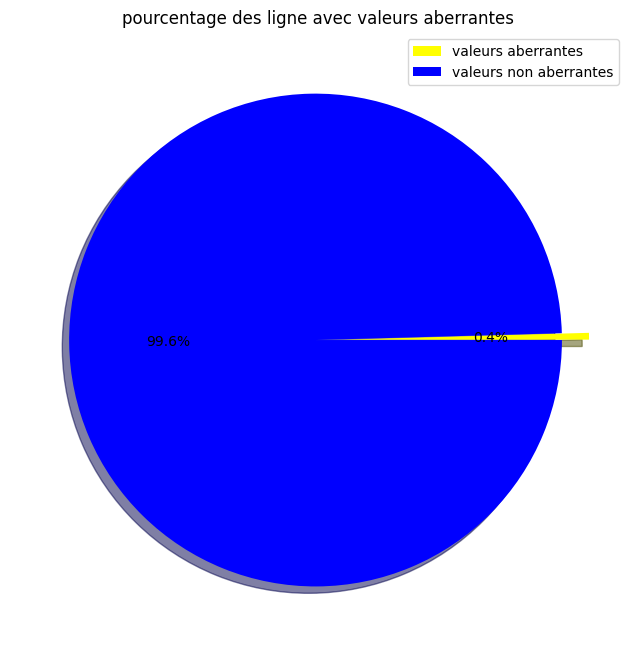

In [102]:
plt.figure(figsize=(8,8))
plt.pie(x=[ab_values_indexes.__len__(),df.shape[0]-ab_values_indexes.__len__()],colors=couleurs,explode=[0.1,0.01],shadow=True,autopct='%1.1f%%')
plt.legend(['valeurs aberrantes','valeurs non aberrantes'])
plt.title('pourcentage des ligne avec valeurs aberrantes')
plt.show()

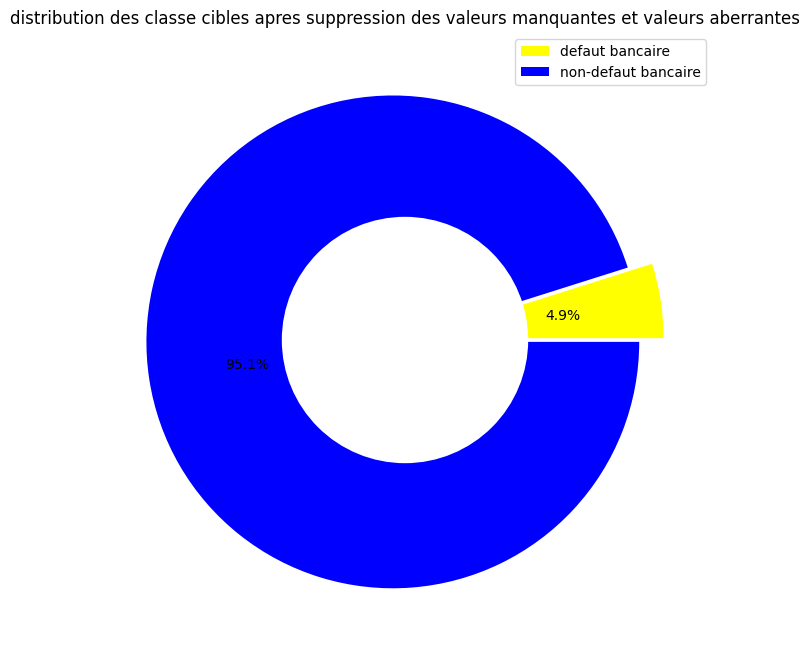

In [103]:
df.dropna(inplace=True)
df.drop(index=ab_values_indexes,inplace=True)
distribution_target(df,' apres suppression des valeurs manquantes et valeurs aberrantes')

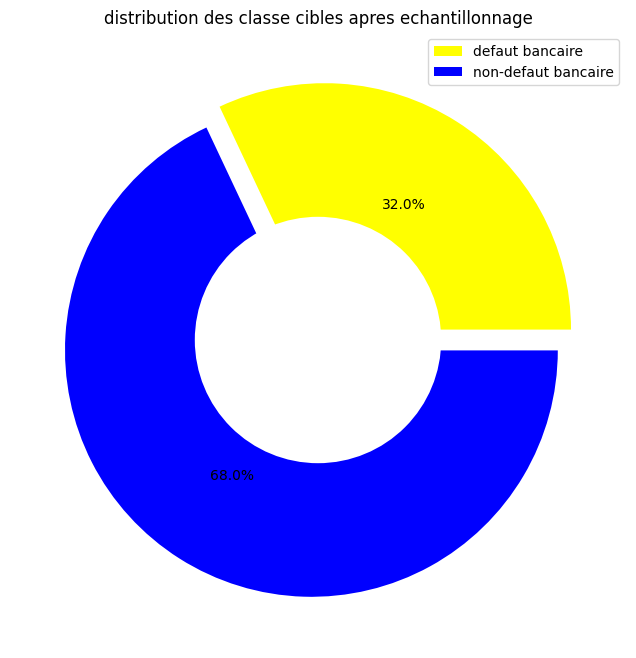

In [104]:
df=replace_inf_with_max(df)
x,y=underSampling_RENN(df)
distribution_target(y,' apres echantillonnage')

calculer correlation

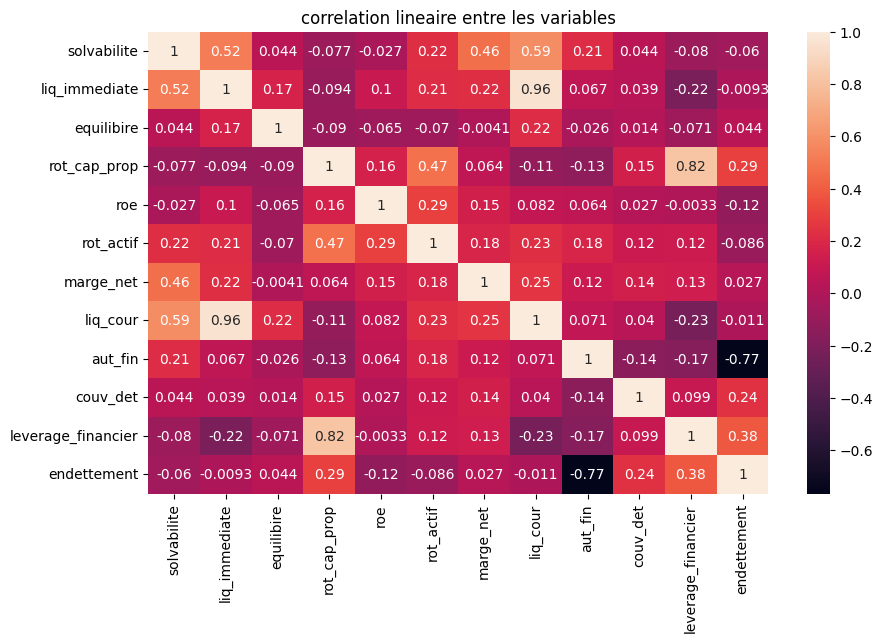

In [105]:
corr_check(x)

In [106]:
#les couples avec correlation :
corrs=[
('liq_cour','liq_immediate'),
('leverage_financier','rot_cap_prop'),
('endettement','aut_fin'),
]

In [107]:
#p value des correlation trouvé (si p_value<0.05 correlation est prise en compte)
print("p-value de la correlation entre ('liq_cour','liq_immediate'): {:.2f}".format(pearsonr(x['liq_cour'],x['liq_immediate'])[1]))
print("p-value de la correlation entre ('leverage_financier','rot_cap_prop'): {:.2f}".format(pearsonr(x['leverage_financier'],x['rot_cap_prop'])[1]))
print("p-value de la correlation entre ('endettement','aut_fin'): {:.2f}".format(pearsonr(x['endettement'],x['aut_fin'])[1]))

p-value de la correlation entre ('liq_cour','liq_immediate'): 0.00
p-value de la correlation entre ('leverage_financier','rot_cap_prop'): 0.00
p-value de la correlation entre ('endettement','aut_fin'): 0.82


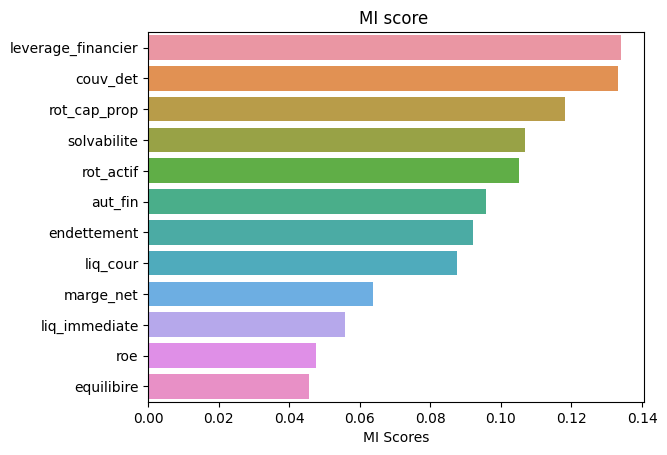

Index(['leverage_financier', 'couv_det', 'rot_cap_prop', 'solvabilite',
       'rot_actif', 'aut_fin', 'endettement', 'liq_cour', 'marge_net',
       'liq_immediate', 'roe', 'equilibire'],
      dtype='object')

In [108]:
#de chaque couple avec p_value<0.05 on choisit une colonne avec le moins mi score a supprimer
make_mi_scores(x,y)

In [109]:
to_delete=['liq_immediate','rot_cap_prop']
dropping=ColumnTransformer([('dropping','drop',to_delete)],remainder='passthrough')

In [110]:
 
model_svc=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',SVC(C=100,gamma=1,kernel='rbf',random_state=0))])
svc_res=test_valid(model_svc,x,y)

tn: 145, fp: 14, fn: 18, tp: 70


In [111]:
model_randomForest=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',RandomForestClassifier(500,criterion='gini',random_state=0))])
rf_res=test_valid(model_randomForest,x,y)

tn: 153, fp: 6, fn: 17, tp: 71


In [112]:
model_gardiantBoost=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',XGBClassifier(objective='binary:logistic',gamma=0.5,colsample_bytree=0.75,learning_rate=0.1,max_depth=6,min_child_weight=1,n_estimators=180,subsample=1.0,random_state=0))])
gb_res=test_valid(model_gardiantBoost,x,y)

tn: 158, fp: 1, fn: 15, tp: 73


In [113]:
model_logisticRegression=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',LogisticRegression(C=2.0,penalty='l1',solver='liblinear',random_state=0))])
lr_res=test_valid(model_logisticRegression,x,y)

tn: 154, fp: 5, fn: 69, tp: 19


In [114]:
model_neuralNetwork=Pipeline([('dropping',dropping),('impute',KNNImputer()),('scaling',StandardScaler()),('model',MLPClassifier(alpha=0.05,hidden_layer_sizes=(100,),activation='tanh',max_iter=1000,random_state=0,solver='lbfgs',learning_rate='constant'))])
nn_res=test_valid(model_neuralNetwork,x,y)

tn: 146, fp: 13, fn: 14, tp: 74


d:\python\python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [115]:
results=pd.DataFrame({'SVC':svc_res,'gardiant boost':gb_res,'random forest':rf_res,'logistic regression':lr_res,'neural network':nn_res})
results

,SVC,gardiant boost,random forest,logistic regression,neural network
recall_score,0.795455,0.829545,0.806818,0.215909,0.840909
precision_score,0.833333,0.986486,0.922078,0.791667,0.850575
accuracy_score,0.870445,0.935223,0.906883,0.700405,0.890688
f1_score,0.813953,0.901235,0.860606,0.339286,0.845714


In [116]:
#best model according to the f1_score: gradient boost => we make it in pkl file
pk.dump(model_gardiantBoost,open('model.pkl','ab'))